chr11_57528484-ENSG00000134809.4 is a good candidate
chr1_26077009-ENSG00000158022.6 has a weird pattern when plotting gt vs. expression
another example: chr6_29679887-ENSG00000204644.5

TODO: automate plotting

In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import LogNorm
import os
import seaborn as sns
import scipy.stats
import statsmodels.stats.multitest
import pandas as pd

eur = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/EUR_eSTR_regression.csv", sep="\t")
afr = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/AFR_eSTR_regression.csv", sep="\t")

# Remove near-duplicates
eur["chrom"] = eur["str-gene"].apply(lambda x: (x.split("_")[0]))
eur["start"] = eur["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
eur["start_rounded"] = eur["start"].apply(lambda x: int(x/20)*20)
eur = eur.drop_duplicates(subset=["chrom","start_rounded","gene_name"])
eur = eur.drop(["chrom","start","start_rounded"], axis=1)

afr["chrom"] = afr["str-gene"].apply(lambda x: (x.split("_")[0]))
afr["start"] = afr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
afr["start_rounded"] = afr["start"].apply(lambda x: int(x/20)*20)
afr = afr.drop_duplicates(subset=["chrom","start_rounded","gene_name"])
afr = afr.drop(["chrom","start","start_rounded"], axis=1)

# basic filtering
eur = eur[(eur["sample_n"]>=50) & (~np.isnan(eur["p_values"]))]
afr = afr[(afr["sample_n"]>=50) & (~np.isnan(afr["p_values"]))]

Populating the interactive namespace from numpy and matplotlib


# Get numbers significant

In [2]:
FDRTHRESH = 0.05

def GetGeneLevelFDR(df, fdrthresh=0.05, prefix=None):
    # Get best pval per gene, and adjustment factor
    bygene = df.groupby(["gene_name"], as_index=False).agg({"str-gene": len})
    # Bonferroni adjusted for number of STRs tested
    bygene = bygene.rename({"str-gene": "num.strs.tested"}, axis=1)
    # merge back to main df
    xx = pd.merge(df, bygene[["gene_name","num.strs.tested"]], on=["gene_name"], how="outer")
    # Bonferonni adjustment of pvalues
    xx["genelevel.bf.adj.p"] = xx.apply(lambda x: np.min([1, x["p_values"]*x["num.strs.tested"]]), 1)
    # Find the best STR per gene and do FDR on that
    bestps = xx.groupby(["gene_name"], as_index=False).agg({"genelevel.bf.adj.p": np.min})
    bestps["genelevel.p.adj"] = \
        statsmodels.stats.multitest.multipletests(list(bestps["genelevel.bf.adj.p"]), \
                                                  method="fdr_bh")[1]
    bestps = bestps.rename({"genelevel.p.adj": "best.genelevel.p.adj", 
                           "genelevel.bf.adj.p": "best.genelevel.bf.adj.p"}, axis=1)
    # Merge back to the main one
    xx = pd.merge(xx, bestps, on=["gene_name"])
    xx["best.str"] = (xx["genelevel.bf.adj.p"]==xx["best.genelevel.bf.adj.p"])
    # Determine significance
    xx["sig.genelevel"] = xx.apply(lambda x: x["best.str"] and (x["best.genelevel.p.adj"]<fdrthresh), 1)
    print("Identified %s eSTRs at gene-level FDR (%s): %s"%(np.sum(xx["sig.genelevel"]), prefix, fdrthresh))
    return xx

########### Not collapsed by gene #############################
eur["p.adj"] = statsmodels.stats.multitest.multipletests(list(eur["p_values"]), method="fdr_bh")[1]
afr["p.adj"] = statsmodels.stats.multitest.multipletests(list(afr["p_values"]), method="fdr_bh")[1]

print("Num eSTR - EUR: %s"%eur[eur["p.adj"]<FDRTHRESH].shape[0])
print("Num eSTR - AFR: %s"%afr[afr["p.adj"]<FDRTHRESH].shape[0])

########### Gene-level FDR ####################################
eur_fdr = GetGeneLevelFDR(eur, prefix="EUR")
afr_fdr = GetGeneLevelFDR(afr, prefix="AFR")

Num eSTR - EUR: 55503
Num eSTR - AFR: 403
Identified 3663 eSTRs at gene-level FDR (EUR): 0.05
Identified 84 eSTRs at gene-level FDR (AFR): 0.05


In [3]:
# Merge for comparison
cols = ["str-gene", "gene_name", "sample_n","p_values","slope","error","p.adj","best.str","sig.genelevel","best.genelevel.p.adj"]
data = pd.merge(eur_fdr[cols], afr_fdr[cols], on=["str-gene","gene_name"], suffixes=("_EUR", "_AFR"), how="outer")

# Compare AFR vs. EUR effects

6.431108041328873e-08
(0.6466939093050059, 0.0)


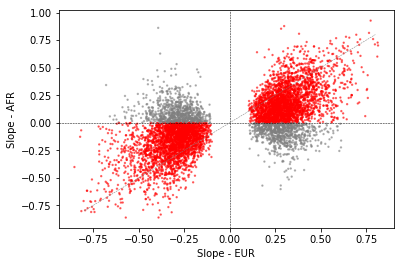

In [4]:
PTHRESH = 0.05/data.shape[0]
print(PTHRESH)
pltdata = data[(data["p.adj_EUR"]<PTHRESH) | (data["p.adj_AFR"]<PTHRESH)]
pltdata = pltdata[pltdata["slope_AFR"].apply(abs) < 1]
pltdata = pltdata[pltdata["slope_EUR"].apply(abs) < 1]

def GetColor(x, col1="slope_EUR", col2="slope_AFR"):
    if np.sign(x[col1])==np.sign(x[col2]):
        return "red"
    else: return "gray"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pltdata["slope_EUR"], pltdata["slope_AFR"], color=pltdata.apply(GetColor, 1), s=2, alpha=0.5);
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
ax.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=0.5)
ax.set_xlabel("Slope - EUR")
ax.set_ylabel("Slope - AFR");
print(scipy.stats.pearsonr(pltdata["slope_EUR"], pltdata["slope_AFR"]))
fig.savefig("Geuvadis-AFRVsEUR.pdf")

# Compare to GTEx

In [5]:
TISSUES = [
    "Adipose-Subcutaneous",
    "Adipose-Visceral",
    "Artery-Aorta",
    "Artery-Tibial",
    "Brain-Caudate",
    "Brain-Cerebellum",
    "Cells-Transformedfibroblasts",
    "Esophagus-Mucosa",
    "Esophagus-Muscularis",
    "Heart-LeftVentricle",
    "Lung",
    "Muscle-Skeletal",
    "Nerve-Tibial",
    "Skin-NotSunExposed",
    "Skin-SunExposed",
    "Thyroid",
    "WholeBlood"
]

###### Load GTEx data ###########
gtex = {} # tissue -> df
for t in TISSUES:
    df = pd.read_csv("raw/master/%s_master.tab"%t, sep="\t")
    lift = pd.read_csv("liftover/%s_hg38.bed"%t, sep="\t", names=["chrom","start_hg38","x","hg19_coords"])
    lift["str.start"] = lift["hg19_coords"].apply(lambda x: int(x.split(":")[1]))
    lift = lift.drop_duplicates()
    df = pd.merge(df, lift[["chrom","str.start","start_hg38"]], on=["chrom","str.start"])
    df = df.rename({"gene.name": "gene_name"}, axis=1)
    df["linreg.pval.adj"] = statsmodels.stats.multitest.multipletests(list(df["linreg.pval"]), \
                                                  method="fdr_bh")[1]
    gtex[t] = df

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/stats/multitest.py:326: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [6]:
eur_fdr["start_hg38"] = eur_fdr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
eur_fdr["chrom"] = eur_fdr["str-gene"].apply(lambda x: x.split("_")[0])

afr_fdr["start_hg38"] = afr_fdr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
afr_fdr["chrom"] = afr_fdr["str-gene"].apply(lambda x: x.split("_")[0])

In [7]:
def MergeGTExGeuvadis(gtex, geu):
    # Round coordinates in case off by a bit
    R = 20
    geu["start_hg38_rounded"] = geu["start_hg38"].apply(lambda x: int(x/R)*R)
    gtex["start_hg38_rounded"] = gtex["start_hg38"].apply(lambda x: int(x/R)*R)
    # Merge on rounded coords and gene
    merged = pd.merge(geu[["chrom","start_hg38_rounded","start_hg38","gene_name","slope","p_values","p.adj"]], \
                        gtex[["chrom","start_hg38_rounded","gene_name","linreg.beta","linreg.pval","linreg.pval.adj"]])
    merged = merged[~np.isnan(merged["linreg.beta"]) & ~np.isnan(merged["slope"])]
    
    # Require some significance threshold in either
    merged = merged[(merged["p.adj"]<FDRTHRESH) | (merged["linreg.pval.adj"]<FDRTHRESH)]
    return merged

for t in TISSUES:
    eur_merged = MergeGTExGeuvadis(gtex[t], eur_fdr)
    afr_merged = MergeGTExGeuvadis(gtex[t], afr_fdr)
    
    print("##### %s ########"%t)
    r_eur, p_eur = scipy.stats.pearsonr(eur_merged["slope"], eur_merged["linreg.beta"])
    print("EUR n=%s r=%.2f p=%.2g"%(eur_merged.shape[0], r_eur, p_eur))
    r_afr, p_afr = scipy.stats.pearsonr(afr_merged["slope"], afr_merged["linreg.beta"])
    print("AFR n=%s r=%.2f p=%.2g"%(afr_merged.shape[0], r_afr, p_afr))

##### Adipose-Subcutaneous ########
EUR n=14345 r=0.52 p=0
AFR n=104 r=0.76 p=3.5e-21
##### Adipose-Visceral ########
EUR n=14109 r=0.51 p=0
AFR n=102 r=0.76 p=1.5e-20
##### Artery-Aorta ########
EUR n=14028 r=0.50 p=0
AFR n=101 r=0.75 p=2.2e-19
##### Artery-Tibial ########
EUR n=14251 r=0.50 p=0
AFR n=104 r=0.76 p=1.7e-20
##### Brain-Caudate ########
EUR n=13196 r=0.39 p=0
AFR n=93 r=0.70 p=5.9e-15
##### Brain-Cerebellum ########
EUR n=13108 r=0.36 p=0
AFR n=95 r=0.67 p=1.5e-13
##### Cells-Transformedfibroblasts ########
EUR n=13906 r=0.57 p=0
AFR n=103 r=0.79 p=3.6e-23
##### Esophagus-Mucosa ########
EUR n=14351 r=0.54 p=0
AFR n=104 r=0.72 p=9.3e-18
##### Esophagus-Muscularis ########
EUR n=14072 r=0.51 p=0
AFR n=99 r=0.76 p=3.3e-20
##### Heart-LeftVentricle ########
EUR n=13901 r=0.47 p=0
AFR n=102 r=0.70 p=2.3e-16
##### Lung ########
EUR n=14446 r=0.55 p=0
AFR n=105 r=0.77 p=3.5e-22
##### Muscle-Skeletal ########
EUR n=14255 r=0.47 p=0
AFR n=103 r=0.75 p=1.4e-19
##### Nerve-Tibial 

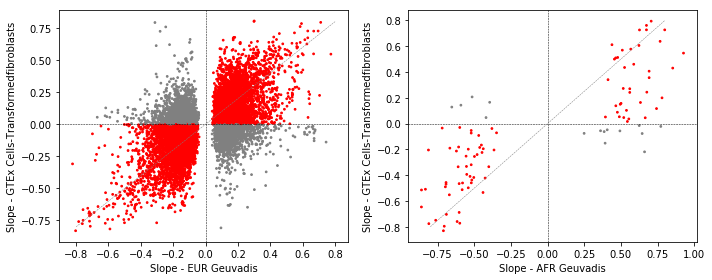

In [8]:
# Plot correlation with Cells-Transformedfibroblasts, which had best correlation above
t = "Cells-Transformedfibroblasts"
eur_merged = MergeGTExGeuvadis(gtex[t], eur_fdr)
afr_merged = MergeGTExGeuvadis(gtex[t], afr_fdr)

fig = plt.figure()
fig.set_size_inches((10, 4))

ax = fig.add_subplot(121)
ax.scatter(eur_merged["slope"], eur_merged["linreg.beta"], s=3, 
           color=eur_merged.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
ax.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=0.5)
ax.set_xlabel("Slope - EUR Geuvadis")
ax.set_ylabel("Slope - GTEx %s"%t);

ax = fig.add_subplot(122)
ax.scatter(afr_merged["slope"], afr_merged["linreg.beta"], s=3, 
           color=afr_merged.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
ax.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=0.5)
ax.set_xlabel("Slope - AFR Geuvadis")
ax.set_ylabel("Slope - GTEx %s"%t);

fig.tight_layout()
fig.savefig("Geuvadis-Vs-GTEx-%s.pdf"%t)

# Merge with het data to find highly polymorphic ones

In [9]:
dfs = []
for chrom in range(1, 23):
    if not os.path.exists("../het-stats/chr%s.period.tab"%chrom): continue
    data = pd.read_csv("../het-stats/chr%s.stats.tab"%chrom, sep="\t")
    dfs.append(data)
data = pd.concat(dfs)

motifs = pd.read_csv("../het-stats/motif_info.tab", sep="\t", names=["chrom", "start","period","motif"])
data = pd.merge(data, motifs, on=["chrom","start"])
data["reflen-bp"] = data.apply(lambda x: (x["end"]-x["start"]), 1)

hetdata = data[(data["motif"].apply(type)==str)]

In [10]:
eur_fdr["start"] = eur_fdr["start_hg38"]
afr_fdr["start"] = afr_fdr["start_hg38"]

In [11]:
eur_het = pd.merge(eur_fdr, hetdata[["chrom","start","het-EUR","het-AFR","nalleles-EUR","nalleles-AFR","motif"]], 
         on=["chrom","start"])
afr_het = pd.merge(afr_fdr, hetdata[["chrom","start","het-EUR","het-AFR","nalleles-EUR","nalleles-AFR","motif"]], 
         on=["chrom","start"])

In [34]:
xx = pd.merge(eur_het[["str-gene","chrom","start","gene_name","motif","p_values","slope"]], 
              afr_het[["chrom","start","gene_name","motif","p_values","slope","het-EUR","het-AFR","nalleles-EUR","nalleles-AFR"]], on=["chrom","start","gene_name","motif"], suffixes=("_EUR","_AFR"))

In [44]:
xx[(xx["motif"]!="A") & (xx["slope_EUR"]<-0.3) & (xx["slope_AFR"]<-0.3) & (xx["nalleles-EUR"]>4)]

,str-gene,chrom,start,gene_name,motif,p_values_EUR,slope_EUR,p_values_AFR,slope_AFR,het-EUR,het-AFR,nalleles-EUR,nalleles-AFR
176829,chr6_29679887-ENSG00000204655.7,chr6,29679887,MOG,AAAC,6.212956e-11,-0.339294,0.003066,-0.389542,0.785,0.794,5,5
176830,chr6_29679887-ENSG00000204644.5,chr6,29679887,ZFP57,AAAC,4.404965e-47,-0.708484,0.000008,-0.690276,0.785,0.794,5,5
196641,chr6_135524360-ENSG00000135541.15,chr6,135524360,AHI1,AT,2.518088e-25,-0.458922,0.107573,-0.344326,0.874,0.842,6,4
485439,chr19_9446366-ENSG00000174652.12,chr19,9446366,ZNF266,AC,8.061687e-33,-0.413589,0.003017,-0.465448,0.717,0.877,5,7
500118,chr19_21499928-ENSG00000197013.4,chr19,21499928,ZNF429,AC,8.095600e-24,-0.330087,0.010306,-0.305092,0.819,0.821,5,6


In [51]:
xx[xx["nalleles-EUR"]>3].sort_values("p_values_EUR")

,str-gene,chrom,start,gene_name,motif,p_values_EUR,slope_EUR,p_values_AFR,slope_AFR,het-EUR,het-AFR,nalleles-EUR,nalleles-AFR
301597,chr11_57528484-ENSG00000134809.4,chr11,57528484,TIMM10,AT,1.008894e-124,0.647605,1.029814e-05,0.480178,0.616,0.604,4,4
153939,chr5_96898573-ENSG00000164308.12,chr5,96898573,ERAP2,A,3.874592e-82,-0.781212,4.199818e-11,-0.775354,0.631,0.707,4,4
250550,chr9_34374902-ENSG00000164978.12,chr9,34374902,NUDT2,A,3.533062e-75,0.630946,1.400088e-04,0.486082,0.586,0.778,4,5
405148,chr16_1842454-ENSG00000180185.7,chr16,1842454,FAHD1,A,2.647903e-69,-0.541091,9.314371e-05,-0.388332,0.557,0.729,4,5
153923,chr5_96887074-ENSG00000164308.12,chr5,96887074,ERAP2,AT,1.522021e-67,0.752644,5.744216e-02,0.297240,0.788,0.803,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75551,chr2_106287913-ENSG00000115652.10,chr2,106287913,UXS1,A,9.999174e-01,0.000004,6.842834e-01,-0.076150,0.732,0.687,4,3
359298,chr13_51404064-ENSG00000102786.9,chr13,51404064,INTS6,AC,9.999394e-01,-0.000004,6.474598e-01,0.082727,0.859,0.945,5,6
99890,chr3_44405952-ENSG00000185219.10,chr3,44405952,ZNF445,A,9.999499e-01,0.000003,9.201404e-01,0.021988,0.561,0.635,4,3
76364,chr2_113995089-ENSG00000115091.5,chr2,113995089,ACTR3,AG,9.999661e-01,-0.000001,9.878146e-01,0.001976,0.637,0.866,4,7
